[nltk_data] Downloading package stopwords to C:\Users\Abdullah
[nltk_data]     Umer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Dataset Shape: (14640, 15)
✅ Columns: Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2 

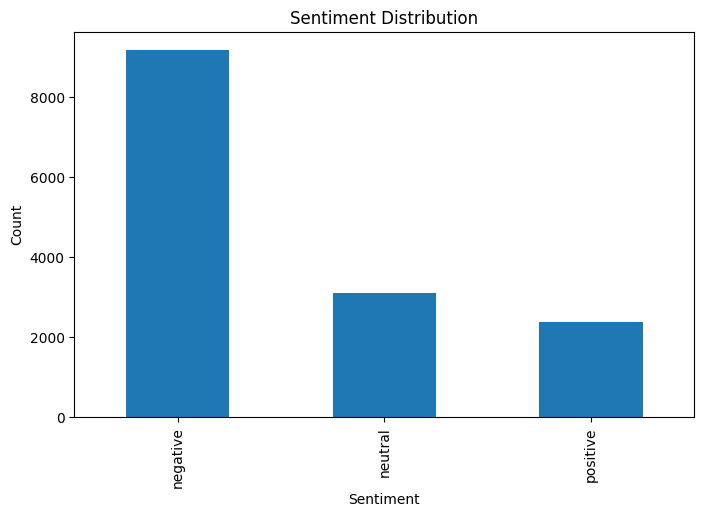

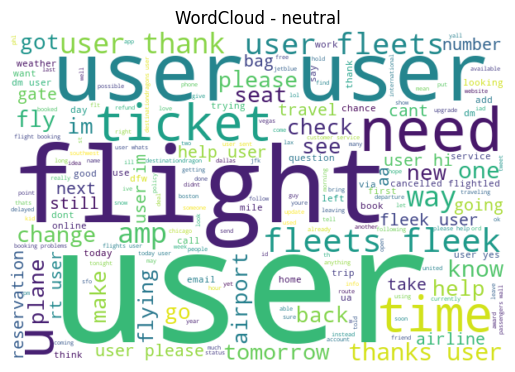

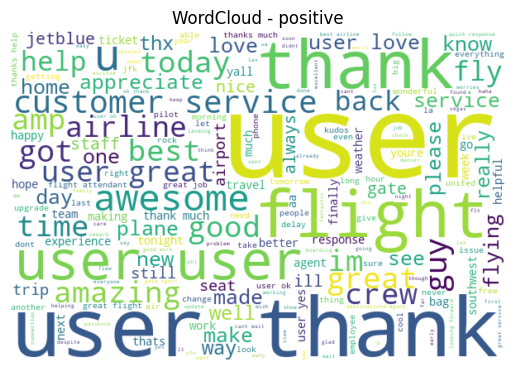

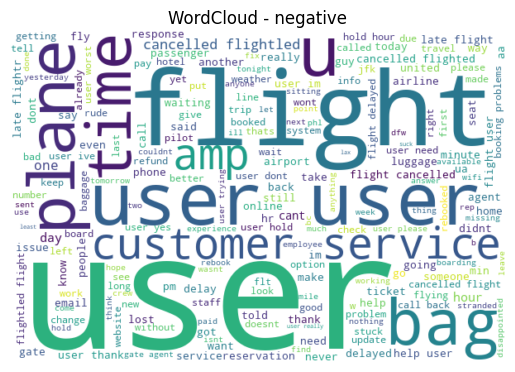

✅ =========== Logistic Regression Results ==========
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1835
     neutral       0.66      0.49      0.57       620
    positive       0.82      0.56      0.66       473

    accuracy                           0.78      2928
   macro avg       0.76      0.66      0.70      2928
weighted avg       0.78      0.78      0.77      2928



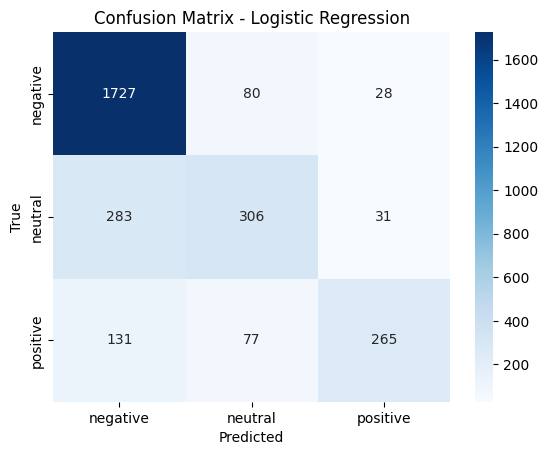

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from transformers import logging
logging.set_verbosity_error()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import transformers as hf_transformers

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# 1. Load Dataset
df = pd.read_csv("C:/Users/Abdullah Umer/Desktop/Brainwave Matrix Solution Internship/Task 2/Twitter US Airline Sentiment DataSet.csv")
print("✅ Dataset Shape:", df.shape)
print("✅ Columns:", df.columns)
print(df.head())

# 2. Basic Data Info
print(df['airline_sentiment'].value_counts())

# Plot sentiment distribution (use pandas plot to avoid seaborn palette deprecation warning)
counts = df['airline_sentiment'].value_counts()
counts.plot(kind='bar', figsize=(8,5))
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# 3. Preprocessing Function
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)      # remove links
    text = re.sub(r"@\w+", "@user", text)    # replace mentions
    text = re.sub(r"#", "", text)            # remove hashtags symbol
    text = re.sub(r"[^a-z\s]", "", text)     # keep only letters and spaces
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_tweet)

# 4. WordCloud for Visualization
for sentiment in df['airline_sentiment'].unique():
    words = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    if len(words.strip()) == 0:
        continue
    wc = WordCloud(width=600, height=400, background_color='white').generate(words)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {sentiment}")
    plt.show()

# 5. Train-Test Split
X = df['clean_text']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 6. Baseline Model (TF-IDF + Logistic Regression)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

print("✅ =========== Logistic Regression Results ==========")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 7. Transformer Model (BERT / DistilBERT)
# Notes:
#  - Ensure you have PyTorch installed (pip install torch torchvision torchaudio)
#  - We avoid new kwargs that might not exist in older transformers
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Build HF dataset and map labels robustly (batched)
dataset = Dataset.from_pandas(df[['clean_text','airline_sentiment']])

# stable label2id (use sorted unique to keep consistent ordering)
unique_labels = sorted(df['airline_sentiment'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def map_labels_batch(batch):
    return {'label': [label2id[l] for l in batch['airline_sentiment']]}

dataset = dataset.map(map_labels_batch, batched=True, remove_columns=['airline_sentiment'])

# Tokenization (batched)
def tokenize(batch):
    return tokenizer(batch['clean_text'], truncation=True, padding='max_length', max_length=64)

dataset = dataset.map(tokenize, batched=True)

# Train/Test split for HuggingFace dataset
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_ds, test_ds = train_test['train'], train_test['test']

# Create the model (classification head will be randomly initialized)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Choose Trainer argument style compatible with your installed transformers
# - older versions may not accept `processing_class` or `evaluation_strategy`.
# - we detect the installed transformers version and adapt to prevent errors/warnings.
tv = hf_transformers.__version__
try:
    major = int(tv.split('.')[0])
except Exception:
    major = 0

# TrainingArguments: use older-compatible flags (do_eval) to avoid eval arg errors
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,                      # older-compatible flag (avoids evaluation_strategy error)
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    dataloader_pin_memory=False         # avoids pin-memory warning on CPU-only machines
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='macro')
    }

# Build Trainer kwargs depending on transformers version
trainer_extra_kwargs = {}
if major >= 5:
    # future-proof: use processing_class when available (avoids tokenizer deprecation warning)
    trainer_extra_kwargs['processing_class'] = tokenizer
else:
    # older versions expect tokenizer=tokenizer (no deprecation warning on older versions)
    trainer_extra_kwargs['tokenizer'] = tokenizer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=tokenizer,   
    compute_metrics=compute_metrics
)


# Train (this will take time on CPU; consider reducing epochs or using a GPU)
trainer.train()

print("=== Transformer (BERT) Evaluation ===")
metrics = trainer.evaluate()
print(metrics)

# 8. Sentiment Trend Over Time
df['date'] = pd.to_datetime(df['tweet_created'], errors='coerce')   # coerce in case of parsing issues
trend = df.groupby([df['date'].dt.date, 'airline_sentiment']).size().unstack().fillna(0)
trend.plot(figsize=(12,6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.show()








